In [8]:
import numpy as np
import scipy as sp
import scipy.optimize as sp_opt
import matplotlib.pyplot as plt

import Robustness.validation as valid

In [21]:
def validate_x_input(x_input):
    # Type check.
    if not isinstance(x_input,(float,np.ndarray)):
        try:
            x_input = np.array(x_input)
        except:
            raise TypeError('validate_x_input - x_input should be a float or np.ndarray')
    
    return x_input

def validate_y_input(y_input):
    # Type check.
    if not isinstance(y_input,(float,np.ndarray)):
        try:
            y_input = np.array(y_input)
        except:
            raise TypeError('validate_y_input - y_input should be a float or np.ndarray')
    
    return y_input

def validate_mean(mean):
    # Type checking.
    if not isinstance(mean,float):
        try:
            mean = float(mean)
        except:
            raise TypeError('validate_mean - mean should be a float')
        
    return mean

def validate_std_dev(std_dev):
    # Type checking
    if not isinstance(std_dev,float):
        try:
            std_dev = float(std_dev)
        except:
            raise TypeError('validate_std_dev - std_dev should be a float')
                
    # Value checking.
    if (std_dev < 0):
        raise ValueError('validate_std_dev - std_dev (standard deviation) cannot be negetive')
        
    return std_dev

def validate_height(height):
    # Type checking
    if not isinstance(height,float):
        try:
            height = float(height)
        except:
            raise TypeError('validate_height - std_dev should be a float')
            
    return height

def validate_x_domain(x_domain):
    # Type checking
    if not isinstance(x_domain,np.ndarray):
        try:
            x_domain = np.array(x_domain,dtype=float)
        except:
            raise TypeError('validate_x_domain - x_domain should be a float np.ndarray.')
            
    # Dimension checking.
    if ((int(x_domain.size) != 2) or (x_domain.shape != (2,))):
        raise TypeError('validate_x_domain - x_domain should have dimensions (2,) with a size of 2')
        
    return x_domain

def validate_noise_domain(noise_domain):
    # Type checking
    if not isinstance(noise_domain,np.ndarray):
        try:
            noise_domain = np.array(noise_domain,dtype=float)
        except:
            raise TypeError('validate_noise_domain - noise_domain should be a float np.ndarray.')
            
    # Dimension checking.
    if ((int(noise_domain.size) != 2) or (noise_domain.shape != (2,))):
        raise TypeError('validate_noise_domain - noise_domain should have dimensions (2,) with a size of 2')
        
    return noise_domain

def validate_n_datapoints(n_datapoints):
    # Type checking
    if not isinstance(n_datapoints,int):
        try:
            n_datapoints = int(n_datapoints)
        except:
            raise TypeError('validate_n_datapoints - n_datapoints should be an integer')
            
    # Value checking
    if (n_datapoints <= 0):
        raise ValueError('validate_n_datapoins - n_datapoints must be greater than zero')
        
    return n_datapoints

def validate_gaussian_count(gaussian_count):
    # Type checking
    if not isinstance(gaussian_count,int):
        try:
            gaussian_count = int(gaussian_count)
        except:
            raise TypeError('validate_gaussian_count - the number of gaussians should be an integer')
    
    # Value checking
    if (gaussian_count <= 0):
        raise ValueError('validate_gaussian_count - it is nonsensical to have a non-positive count')
        
    return gaussian_count

In [24]:
def gaussian_function(x_input,mean,std_dev,height):
    # Input validation of the values.
    x_input = validate_x_input(x_input)
    mean = validate_mean(mean)
    std_dev = validate_std_dev(std_dev)
    height = validate_height(height)    
    
    # Use the equation of a gaussian from Wikipedia:
    y_output = (((1 / std_dev * np.sqrt(2 * np.pi)) 
                 * np.exp(-0.5 * (x_input - (mean/std_dev))**2))
                + height)
    return y_output

def generate_noisy_gaussian(mean=0,std_dev=1,height=0,noise_domain=[-0.1,0.1],
                            x_domain=[-3,3],n_datapoints=10000):
    """
    Generate a gaussian with some aspect of noise.
    
    Input:
        mean = centeral x value
        std_dev = standard deviation of the function
        height = height (y-off set) of the function
        noise_domain = uniform random distribution of noise from perfect gauss function
        x_domain = absolute domain of the gaussian function 
        n_datapoints = total number of input datapoints of gass function
    Output: x_values,y_values
        x_values = the x-axial array of the gaussian function within the domain
        y_values = the y-axial array of the gaussian function within the domain
    """
    # Input validation
    mean = validate_mean(mean)
    std_dev = validate_std_dev(std_dev)
    height = validate_height(height)
    noise_domain = validate_noise_domain(noise_domain)
    x_domain = validate_x_domain(x_domain)
    n_datapoints = validate_n_datapoints(n_datapoints)  
    
    
    # Make the x-axis value array given the domain and the number of points.
    x_values = np.random.uniform(x_domain[0],x_domain[-1],n_datapoints)
    
    # Generate the gaussian function and map to an output with the input parameters.
    y_values = gaussian_function(x_values,mean,std_dev,height)
    
    # Generate an array of noise values equally distributed.
    noise_array = np.random.uniform(noise_domain[0],noise_domain[-1],n_datapoints)
    
    # Add the noise to the optimal gaussian function.
    y_values += noise_array
    
    return x_values,y_values

def generate_noisy_multigaussian(mean_list,std_dev_list,height_list,noise_domain_list,
                                 x_domain_list,gaussian_count=None,
                                 n_datapoints=None,n_datapoints_list=None):
    """
    Generate multiple gaussians with some aspect of noise within one dataset.
    
        Input:
        mean_list = list of centeral x values
        std_dev_list = list of standard deviations of the functions
        height_list = list of heights (y-off set) of the functions
        noise_domain_list = list of uniform random distribution of noise from perfect gauss function
        x_domain_list = absolute domains of the gaussian functions
        gaussian_count = the number of gaussian functions to be made
        n_datapoints = total number of datapoints
        n_datapoints_list = list of number of datapoints (overrides n_datapoints)
    Output: x_values,y_values
        x_values = the x-axial array of the gaussian function within the domain
        y_values = the y-axial array of the gaussian function within the domain
    """
    # Input validation.
    guassian_count = validate_gaussian_count(gaussian_count)
    
    # Check to see if the size of the lists is the same as the gaussian count. If not, then
    # it is impossible to generate the gaussians. However, if not provided, adapt the value.
    if (gaussian_count is None):
        gaussian_count = len(mean_list)

    if (gaussian_count != len(mean_list)):
        raise TypeError('generate_noisy_multigaussian - length of mean_list does not equal gaussian_count')
    elif (gaussian_count != len(std_dev_list)):
        raise TypeError('generate_noisy_multigaussian - length of std_dev_list does not equal gaussian_count')
    elif (gaussian_count != len(height_list)):
        raise TypeError('generate_noisy_multigaussian - length of height_list does not equal gaussian_count')
    elif (gaussian_count != len(noise_domain_list)):
        raise TypeError('generate_noisy_multigaussian - length of noise_domain_list does not equal gaussian_count')
    elif (gaussian_count != len(x_domain_list)):
        raise TypeError('generate_noisy_multigaussian - length of x_domain_list does not equal gaussian_count')
    else:
        pass
    
    # Check if the user defined some number of datapoints or a list of the
    # number of datapoints. Adapt as nessisary.
    if ((n_datapoints is None) and (n_datapoints_list is None)):
        raise ValueError('generate_noisy_multigaussian - n_datapoints or n_datapoints_list must be filled')
    elif (n_datapoints_list is None):
        # Each gaussian function should have about the same amount of points.
        n_subpoint = np.ceil(n_datapoints/gaussian_count)
        n_datapoints_list = np.full(gaussian_count,n_subpoint)
    elif (n_datapoints is None):
        
    
    # Variables to store the datapoints from the generation of multiple gaussians.
    x_points = []
    y_points = []
    for gaussiandex in range(gaussian_count):
        # Generate one gaussian.
        temp_x_points,temp_y_points = generate_noisy_gaussian(mean_list[gaussiandex],
                                                              std_dev_list[gaussiandex],
                                                              height_list[gaussiandex],
                                                              noise_domain_list[gaussiandex],
                                                              x_domain_list[gaussiandex],
                                                              n_datapoints_list[gaussiandex])
        # Store that one gaussian into the main list to send back later.
        x_points.append(temp_x_points)
        y_points.append(temp_y_points)    
    
    # Transfrom into numpy arrays for better indexing.
    x_points = np.array(x_points)
    y_points = np.array(y_points)
    
    # Check if both arrays are the same length.
    if (len(x_points) == len(y_points)):
        raise TypeError('generate_noisy_multigaussian - the length of x_points and y_points are not the same')
    
    # If the user wanted n_datapoints instead of providing the list, check if
    # the number of points is valid. If over, cut out random points, if less,
    # return error (it should not be nessisary).
    if (n_datapoints is not None):        
        if ((len(x_points) < n_datapoints) or (len(y_datapoints) < n_datapoints)):
            raise TypeError('generate_noisy_multigaussian - x_points and y_points have less than desireable datapoint counts')
        elif ((len(x_points) > n_datapoints) or (len(y_datapoints) > n_datapoints)):
            # Trim points at random.
            dataset_length = len(x_points)
            removed_indexes = np.random.randint(0,dataset_length,dataset_length - n_datapoints)
            x_points = np.delete(x_points,removed_indexes)
            y_points = np.delete(y_points,removed_indexes)
        elif ((len(x_points) == n_datapoints) and (len(y_datapoints) == n_datapoints)):
            # This is perfectly normal.
            pass
        else:
            raise TypeError('This is not normal.')
            
    return x_points,y_points
            
        
        
def fit_gaussian(x_values,y_values):
    """
    Fit a gaussian fucntion with 4 degrees of freedom.
    
    Input:
        x_values = the x-axial array of the values
        y_values = the y-axial array of the values
        
    Returns: fit_parameters[mean,std_dev,height],covariance
        fit_parameters = an array containing the values of the fit
        mean = the centeral value of the gaussian
        std_dev = the standard deviation of the gaussian
        height = the height of the gaussian function along the x-axis
        covariance = a convariance matrix of the fit
    """
    # Input validation
    x_values = validate_x_input(x_values)
    y_values = validate_y_input(y_values)
    
    # Use scipy's curve optimization function for the gaussian function.
    fit_parameters,covariance = sp_opt.curve_fit(gaussian_function,x_values,y_values)
    
    return fit_parameters,covariance

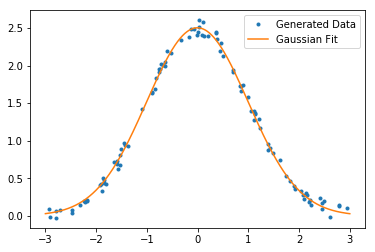

Central Mean:   -0.004293857779187113
Std dev:   1.0017394085053088
Height:   0.000817819619704543


In [26]:
# Define the number of data points.
n_datapoints=100

# Generate the noisy gaussian, use the default options execpt for the data points.
x_values,y_values = generate_noisy_gaussian(n_datapoints=n_datapoints)

# Generate a fit of the noisy gaussian data.
fit_parameters,covariance = fit_gaussian(x_values,y_values)

# Reassign the fit parameters, generate values to plot the gaussian function.
fit_mean,fit_std_dev,fit_height = fit_parameters
fit_x_values = np.linspace(-3,3,n_datapoints*10)
fit_y_values = gaussian_function(fit_x_values,fit_mean,fit_std_dev,fit_height)

# Plot the information of the generated gaussian data and the fit.
plt.plot(x_values,y_values,'.',label='Generated Data')
plt.plot(fit_x_values,fit_y_values,label='Gaussian Fit')
plt.legend()
plt.show()

# Print the values of the fitted parameters.
print('Central Mean:  ',fit_parameters[0])
print('Std dev:  ',fit_parameters[1])
print('Height:  ',fit_parameters[2])

In [78]:
# Using Monte-Carlo methods for testing.
bin_size = 10000
bin_count = 1000

# Delta parameters
delta_mean = 1e-3
delta_std_dev = 1e-3
delta_height = 1e-3

# Inital conditions
test_mean = 1
test_std_dev = 1
test_height = 0

# Generate a large dataset of potenial points and their results+noise.
n_datapoints = 1000000
x_domain = [-3,3]
#noise_domain = [-1,1]
max_absolute_noise = 10
test_count = 1000

# Extra stuff to ensure there is no uneeded loop time
mean_break = False
std_dev_break = False
height_break = False

# Test the algorithim under increasing values of the noise domain.
for noisedex in np.linspace(0,max_absolute_noise,test_count):
    noise_domain = [-noisedex,noisedex]
    
    # Archive the information data to conduct stats.
    list_fit_mean = []
    list_fit_std_dev = []
    list_fit_height = []
    
    x_value_array,y_value_array = generate_noisy_gaussian(mean=test_mean,std_dev=test_std_dev,height=test_height,
                                                      x_domain=x_domain,noise_domain=noise_domain,
                                                      n_datapoints=n_datapoints)

    # From the dataset, generate the bins from random values, double sampling 
    # between bins is allowed.
    for bindex in range(bin_count):
        # Create a list of random indexes and extract a subset of the data.
        selected_indexes = np.random.randint(0,n_datapoints,size=bin_size)
        x_values_bin = np.array(x_value_array[selected_indexes])
        y_values_bin = np.array(y_value_array[selected_indexes])
        
        # Fit the values in each bin with a gaussian fit.
        fit_parameters,covariance = fit_gaussian(x_values_bin,y_values_bin)
        """
        # Generate an array for plotting values. Reusing the n_datapoints variable.
        plotting_x_values = np.linspace(x_domain[0],x_domain[-1],n_datapoints)
        plotting_y_values = gaussian_function(plotting_x_values,
                                          fit_parameters[0],fit_parameters[1],fit_parameters[2])
        
        # Print the information
        # Plot the information of the generated gaussian data and the fit.
        plt.plot(x_values_bin,y_values_bin,'.',label='Generated Data')
        plt.plot(plotting_x_values,plotting_y_values,label='Gaussian Fit')
        plt.legend()
        plt.show()
        
        # Print the values of the fitted parameters.
        print('Central Mean:  ',fit_parameters[0])
        print('Std dev:  ',fit_parameters[1])
        print('Height:  ',fit_parameters[2])
    
        # A dividing line for easier reading.
        print('==========================================')
        """
        
        # Save the fit parameters for the current run.
        list_fit_mean.append(fit_parameters[0])
        list_fit_std_dev.append(fit_parameters[1])
        list_fit_height.append(fit_parameters[2])
    
        # Remove unneeded values (just to make sure it is not repeated).
        del selected_indexes,fit_parameters
        #print(bindex)
    
    # Test the averages of the fitted values and see if the difference is too large.
    if (np.abs(np.average(list_fit_mean) - test_mean) > delta_mean):
        print('Mean failed at a noisedex of  ', noisedex)
        mean_break = True
    if (np.abs(np.average(list_fit_std_dev) - test_std_dev) > delta_std_dev):
        print('Std Dev failed at a noisedex of  ', noisedex)
        std_dev_break = True
    if (np.abs(np.average(list_fit_height) - test_height) > delta_height):
        print('Height failed at a noisedex of  ', noisedex)
        height_break = True
        
    # If all three values broke, end the loop.
    if (mean_break and std_dev_break and height_break):
        print('End!')
        break
    else:
        pass
        #print(noisedex)

Mean failed at a noisedex of   0.5505505505505506
Height failed at a noisedex of   0.5505505505505506
Mean failed at a noisedex of   0.6806806806806807
Mean failed at a noisedex of   0.6906906906906907
Height failed at a noisedex of   0.7207207207207207
Mean failed at a noisedex of   0.7507507507507507
Std Dev failed at a noisedex of   0.7507507507507507
End!


In [76]:
print(np.abs(np.average(list_fit_mean) - test_mean),
np.abs(np.average(list_fit_std_dev) - test_std_dev),
np.abs(np.average(list_fit_height) - test_height))

0.002935609132028727 0.0021537569166176773 0.0011012544189502964


In [2]:
import gaussian_demonstration as gd

TypeError: Input int value is not transformable into a int value.    -Kyubey

In [16]:
tup = valid.validate_tuple((2,3,4),length=10)

ShapeError: The input tuple is not the correct length.    --Kyubey